(stats_tutorial)=
# Intro to the stats module

In [1]:
from scipy import stats
import numpy as np
from xarray_einstats.stats import XrContinuousRV, rankdata, hmean, skew, median_abs_deviation
from xarray_einstats.tutorial import generate_mcmc_like_dataset

In [2]:
ds = generate_mcmc_like_dataset(11)
ds

<xarray.Dataset> Size: 6kB
Dimensions:  (plot_dim: 20, chain: 4, draw: 10, team: 6, match: 12)
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 80B 0 1 2 3 4 5 6 7 8 9
  * team     (team) <U1 24B 'a' 'b' 'c' 'd' 'e' 'f'
Dimensions without coordinates: plot_dim, match
Data variables:
    x_plot   (plot_dim) float64 160B 0.0 0.5263 1.053 1.579 ... 8.947 9.474 10.0
    mu       (chain, draw, team) float64 2kB 0.2296 0.5383 ... 0.4452 2.004
    sigma    (chain, draw) float64 320B 0.3703 0.00899 0.1398 ... 0.2246 0.2875
    score    (chain, draw, match) int64 4kB 1 0 0 1 4 1 1 0 ... 0 0 2 1 2 1 0 2

(stats_tutorial/dists)=
## Probability distributions
### Initialization
Initialization takes a class from an external library that defines distributions with array inputs and the positional/keyword arguments needed to initialize it. Tested distributions are:

* SciPy distributions
* PreliZ distributions
* SciPy random variables (introduced in SciPy 1.14).

:::{note}
Positional and keyword arguments are broadcasted with all other inputs, but they are then reconstructed and passed as is. For example: `preliz.Normal(0, 1)` is valid, so `XrContinuousRV(pz.Normal, 0, 1)` is also valid but `scipy.stats.Normal(0, 1)` is **not** valid only keyword arguments are accepted, so the same will apply when wrapping with with xarray-einstats.

Moreover, the use of `XrContinuousRV` and `XrDiscreteRV` only changes for some of the methods like pdf/pmf. However, PreliZ always uses pdf, even for discrete distributions so it needs to always be wrapped through `XrContinuousRV`
:::

In [3]:
dist = stats.norm      # SciPy distribution
# import preliz as pz
# dist = pz.Normal     # PreliZ distribution
# dist = stats.Normal  # SciPy random variable

norm = XrContinuousRV(dist, ds["mu"], ds["sigma"])

### Using its methods
Once initialized, you can use its methods exactly as you'd use them with frozen scipy distributions or preliz distributions. The only two differences are
1. They now take scalars or DataArrays as inputs, arrays are only accepted as the arguments
   on which to evaluate the methods (in scipy docs they are represented by `x`, `k` or `q` depending on the method)
2. `size` behaves differently in the `rvs` method; here `size` represents the `shape` of a single draw. This ensures that you don't need to care about any broadcasting or alignment of arrays, `xarray_einstats` does this for you and will return a DataArray with combined shape `(*size, *broadcasted_input_shape)`.

You can generate 100 random draws from the initialized distribution. As we have mentioned and unlike what would happen with scipy the output won't have shape 100 but instead will have shape `100, *broadcasted_input_shape`. xarray generates the `broadcasted_input_shape` and `size` is independent from it so you can relax and not care about broadcasting.

In [4]:
norm.rvs(size=100)

<xarray.DataArray (rv_dim0: 100, chain: 4, draw: 10, team: 6)> Size: 192kB
-0.2056 0.492 1.427 0.215 0.3821 3.649 ... 0.4924 -0.1149 0.1473 0.4786 1.957
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 80B 0 1 2 3 4 5 6 7 8 9
  * team     (team) <U1 24B 'a' 'b' 'c' 'd' 'e' 'f'
Dimensions without coordinates: rv_dim0

If the dimension names are not provided, `xarray_einstats` assings `rv_dim#` as dimension name as many times as necessary. To define the names manually you can use the `dims` argument:

In [5]:
norm.rvs(size=(5, 3), dims=["subject", "batch"])

<xarray.DataArray (subject: 5, batch: 3, chain: 4, draw: 10, team: 6)> Size: 29kB
0.1381 0.5446 1.332 -0.1725 -0.507 3.723 ... 0.1261 -0.1208 0.8665 0.4237 1.732
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 80B 0 1 2 3 4 5 6 7 8 9
  * team     (team) <U1 24B 'a' 'b' 'c' 'd' 'e' 'f'
Dimensions without coordinates: subject, batch

In the output above we'll often want to provide coordinate values to the new dimensions. `.rvs` takes a `coords` argument which can be used for that, but it isn't much of an improvement over `.rvs(...).assign_coords(coords)`. It is also possible however to skip `size` and `dims` altogether and use `coords` to inform both:

In [6]:
subject = [
    "Monstera deliciosa", "Monstera borsigiana", "Monstera siltepecana",
    "Monstera variegata", "Monstera pinnatipartita"
]
batch = ["March", "June", "October"]
norm.rvs(coords={"subject": subject, "batch": batch})

<xarray.DataArray (subject: 5, batch: 3, chain: 4, draw: 10, team: 6)> Size: 29kB
-0.1143 0.2968 0.7802 0.4579 -0.3176 4.263 ... 0.2388 -0.3806 0.2841 0.5201 2.1
Coordinates:
  * subject  (subject) <U23 460B 'Monstera deliciosa' ... 'Monstera pinnatipa...
  * batch    (batch) <U7 84B 'March' 'June' 'October'
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 80B 0 1 2 3 4 5 6 7 8 9
  * team     (team) <U1 24B 'a' 'b' 'c' 'd' 'e' 'f'

The behaviour for other methods is similar:

In [7]:
norm.logpdf(ds["x_plot"])

<xarray.DataArray 'x_plot' (plot_dim: 20, chain: 4, draw: 10, team: 6)> Size: 38kB
-0.1177 -0.9821 -4.519 0.06682 0.02491 ... -594.3 -600.6 -561.9 -551.8 -386.4
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 80B 0 1 2 3 4 5 6 7 8 9
  * team     (team) <U1 24B 'a' 'b' 'c' 'd' 'e' 'f'
Dimensions without coordinates: plot_dim

For convenience, you can also use {term}`array_like` input which is converted to a DataArray under the hood. In such cases, the dimension name is `quantile` for `ppf` and `isf`, `point` otherwise. In both cases, the values passed as input are preserved as coordinate values.

In [8]:
norm.ppf([.25, .5, .75])

<xarray.DataArray (quantile: 3, chain: 4, draw: 10, team: 6)> Size: 6kB
-0.02018 0.2885 0.8726 -0.204 -0.1332 ... 0.2786 0.2264 0.5523 0.6391 2.198
Coordinates:
  * quantile  (quantile) float64 24B 0.25 0.5 0.75
  * chain     (chain) int64 32B 0 1 2 3
  * draw      (draw) int64 80B 0 1 2 3 4 5 6 7 8 9
  * team      (team) <U1 24B 'a' 'b' 'c' 'd' 'e' 'f'

In [9]:
pdf = norm.pdf(np.linspace(-5, 5))
pdf

<xarray.DataArray (point: 50, chain: 4, draw: 10, team: 6)> Size: 96kB
5.321e-44 2.898e-49 4.753e-60 5.206e-41 ... 3.563e-57 4.449e-55 3.664e-24
Coordinates:
  * point    (point) float64 400B -5.0 -4.796 -4.592 -4.388 ... 4.592 4.796 5.0
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 80B 0 1 2 3 4 5 6 7 8 9
  * team     (team) <U1 24B 'a' 'b' 'c' 'd' 'e' 'f'

Plot a subset of the pdf we just calculated with matplotlib.

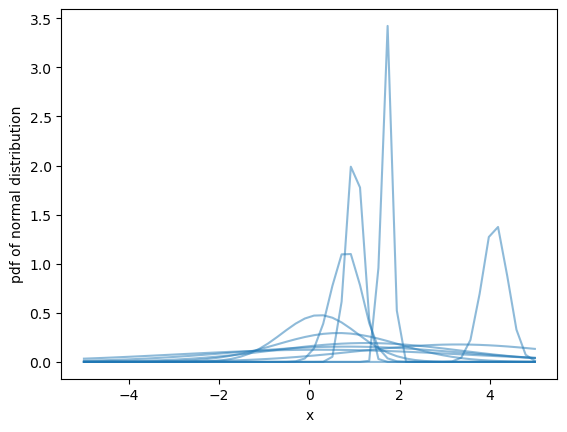

In [10]:
import matplotlib.pyplot as plt
plt.rcParams["figure.facecolor"] = "white"

fig, ax = plt.subplots()
ax.plot(pdf.point, pdf.sel(team="d", chain=2), color="C0", alpha=.5)
ax.set(xlabel="x", ylabel="pdf of normal distribution", );

(stats_tutorial/other)=
## Other functions
The rest of the functions in the module have a very similar API to their scipy counterparts, the only differences are:

* They take `dims` instead of `axis`. Moreover, `dims` can be `str` or a sequence of `str` instead of a single integer only as supported by `axis`.
* Arguments that take {term}`numpy:array_like` as values take `DataArray` inputs instead. For example the `scale` argument in {func}`~xarray_einstats.stats.median_abs_deviation`
* They accept extra arbitrary kwargs, that are passed to {func}`xarray.apply_ufunc`.

Here are some examples of using functions in the `stats` module of `xarray_einstats` with `dims` argument instead of `axis`.

In [11]:
hmean(ds["mu"], dims="team")

<xarray.DataArray 'mu' (chain: 4, draw: 10)> Size: 320B
0.1588 0.2123 0.5543 0.7826 0.1913 0.6035 ... 0.1269 0.712 0.3044 0.1936 0.1223
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 80B 0 1 2 3 4 5 6 7 8 9

In [12]:
rankdata(ds["score"], dims=("chain", "draw"), method="min")

<xarray.DataArray 'score' (match: 12, chain: 4, draw: 10)> Size: 4kB
14 14 14 14 14 31 14 1 31 14 31 1 14 1 ... 15 15 15 15 15 1 34 15 15 1 34 34 34
Dimensions without coordinates: match, chain, draw

:::{important}
The statistical summaries and other statistical functions can take both {class}`~xarray.DataArray` and {class}`~xarray.Dataset`. Methods in probability functions and functions in linear algebra module
are tested only on `DataArray`s.

When using `Dataset` inputs, you must make sure that all the dimensions in `dims` are
present in _all_ the `DataArray`s within the `Dataset`.
:::

In [13]:
skew(ds[["score", "mu", "sigma"]], dims=("chain", "draw"))

<xarray.Dataset> Size: 176B
Dimensions:  (match: 12, team: 6)
Coordinates:
  * team     (team) <U1 24B 'a' 'b' 'c' 'd' 'e' 'f'
Dimensions without coordinates: match
Data variables:
    score    (match) float64 96B 1.466 0.2149 0.6788 1.361 ... 1.099 1.156 1.265
    mu       (team) float64 48B 0.8152 1.84 2.102 1.806 1.091 0.9678
    sigma    float64 8B 1.314

In [14]:
median_abs_deviation(ds)

<xarray.Dataset> Size: 32B
Dimensions:  ()
Data variables:
    x_plot   float64 8B 2.632
    mu       float64 8B 0.4878
    sigma    float64 8B 0.39
    score    float64 8B 1.0

In [15]:
%load_ext watermark
%watermark -n -u -v -iv -w -p xarray_einstats,xarray

Last updated: Thu, 19 Feb 2026

Python implementation: CPython
Python version       : 3.13.9
IPython version      : 9.7.0

xarray_einstats: 0.10.0
xarray         : 2025.11.0

matplotlib     : 3.10.8
numpy          : 2.3.5
scipy          : 1.16.3
xarray_einstats: 0.10.0

Watermark: 2.6.0

